mükemmel, şimdi **2) Autoencoder ile Anomali Tespiti (Tabular)** adımını “tek parça, Jupyter’da çalışır” bir akışla veriyorum.
**Nereye ekleyeceğim?** → En temizi: **yeni bir notebook hücresine** aşağıdaki blokları sırasıyla çalıştır. Sadece **dosya yolunu** kendi verine göre değiştirmen yeterli.

Aşağıdaki akış:
veri → ölçekleme → train/valid/test → **yalnızca normallerle AE eğitimi** → rekonstrüksiyon hatasıyla **anomali skoru** → **eşik seçimi (F1-opt ve Precision≥x)** → metrikler + grafikler → **modeli kaydet / yükle** → **tek satır tahmin**.

---

# 0) Kurulum ve import’lar

In [33]:
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler #StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             classification_report, confusion_matrix)
np.random.seed(42); tf.random.set_seed(42)

print("TF:", tf.__version__)

TF: 2.11.1


# 1) Veriyi oku

In [22]:
CSV_PATH = "Credit_Card_Applications.csv"   # ULB Credit Card Fraud (Time, V1..V28, Amount, Class)

df = pd.read_csv(CSV_PATH)
assert "Class" in df.columns, "Class etiketi yok!"

# 1) ID'yi at
for col in ["CustomerID", "customerID", "CustomerId", "ID", "Id"]:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped ID column: {col}")

        
y = df["Class"].values.astype(int)
X = df.drop(columns=["Class","CustomerID"])

print("Şekil:", X.shape, "| Fraud oranı:", y.mean())
X.head(3)

Şekil: (690, 14) | Fraud oranı: 0.4449275362318841


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1


# 2) Train/Valid/Test ve ölçekleme

**Neden?** AE mesafe/rekonstrüksiyon temelli → **ölçekleme şart**. Aykırı değerlere dayanıklılık istersen `RobustScaler` kullan.

In [23]:

# 70/15/15 bölüyoruz (önce 70/30, sonra 30'u 15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Ölçekleyici: RobustScaler (outlier dayanıklı) ya da StandardScaler
scaler = RobustScaler()
# scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)

# AE'yi sadece NORMAL sınıfla eğitmek iyi pratik (unsupervised outlier)
X_train_norm = X_train_s[y_train == 0]
print("Train normal sayısı:", X_train_norm.shape[0], " / Train toplam:", X_train_s.shape[0])


Train normal sayısı: 268  / Train toplam: 483


# 3) Autoencoder (dense) modeli

**Neden böyle?** Küçük bir “sıkıştır–aç” (bottleneck) mimarisi, normal paterni öğrenmeye zorlar.

In [24]:
input_dim = X_train_s.shape[1]

def build_ae(d=input_dim, latent=16, hidden=32, dropout=0.0):
    inp = layers.Input(shape=(d,))
    x = layers.Dense(hidden, activation="relu")(inp)
    if dropout>0: x = layers.Dropout(dropout)(x)
    z = layers.Dense(latent, activation="relu", name="bottleneck")(x)
    x = layers.Dense(hidden, activation="relu")(z)
    out = layers.Dense(d, activation=None)(x)  # regresyon; aktivasyon yok
    return models.Model(inp, out, name="tabular_ae")

ae = build_ae(latent=16, hidden=32, dropout=0.0)
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
ae.summary()

Model: "tabular_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_3 (Dense)             (None, 32)                480       
                                                                 
 bottleneck (Dense)          (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 14)                462       
                                                                 
Total params: 2,014
Trainable params: 2,014
Non-trainable params: 0
_________________________________________________________________


# 4) Eğitim (yalnızca normallerle)

In [25]:
ckpt = callbacks.ModelCheckpoint("ae_fraud_best.keras", save_best_only=True,
                                 monitor="val_loss", verbose=1)
early = callbacks.EarlyStopping(monitor="val_loss", patience=8,
                                restore_best_weights=True, verbose=1)
plateau = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=3, min_lr=1e-5, verbose=1)

history = ae.fit(
    X_train_norm, X_train_norm,
    validation_data=(X_valid_s, X_valid_s),  # valid’i tamamen görsün: hatayı ölçeceğiz
    epochs=100, batch_size=256, verbose=1,
    callbacks=[ckpt, early, plateau]
)

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 1.0813
Epoch 1: val_loss improved from inf to 3.62569, saving model to ae_fraud_best.keras
2/2 [==============================] - 1s 211ms/step - loss: 1.0748 - val_loss: 3.6257 - lr: 0.0010
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 1.0570
Epoch 2: val_loss improved from 3.62569 to 3.51996, saving model to ae_fraud_best.keras
2/2 [==============================] - 0s 78ms/step - loss: 1.0392 - val_loss: 3.5200 - lr: 0.0010
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 1.0143
Epoch 3: val_loss improved from 3.51996 to 3.42265, saving model to ae_fraud_best.keras
2/2 [==============================] - 0s 85ms/step - loss: 1.0083 - val_loss: 3.4227 - lr: 0.0010
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 0.9786
Epoch 4: val_loss improved from 3.42265 to 3.33378, saving model to ae_fraud_best.keras
2/2 [==============================] - 0s 85ms/step - loss

# 5) Öğrenme eğrisi

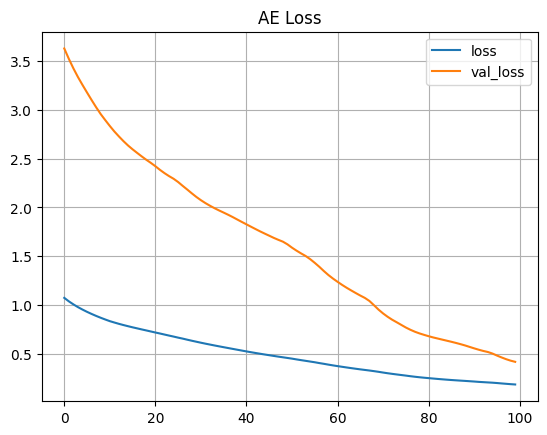

In [26]:
pd.DataFrame(history.history)[["loss","val_loss"]].plot(grid=True, title="AE Loss"); plt.show()

# 6) Skor = rekonstrüksiyon hatası

**Neden?** AE normal veriyi iyi yeniden kurar; anomaliyi kötü → **hata yüksek = anomali**.


In [27]:
# Valid ve Test için rekonstrüksiyon hataları
valid_pred = ae.predict(X_valid_s, verbose=0)
test_pred  = ae.predict(X_test_s,  verbose=0)

err_valid = np.mean((X_valid_s - valid_pred)**2, axis=1)  # MSE
err_test  = np.mean((X_test_s  - test_pred )**2, axis=1)

print("VAL  ROC-AUC:", roc_auc_score(y_valid, err_valid),
      "| PR-AUC:", average_precision_score(y_valid, err_valid))
print("TEST ROC-AUC:", roc_auc_score(y_test,  err_test ),
      "| PR-AUC:", average_precision_score(y_test,  err_test ))

VAL  ROC-AUC: 0.7707856598016781 | PR-AUC: 0.7066139012988958
TEST ROC-AUC: 0.793103448275862 | PR-AUC: 0.7705948086711634


# 7) Eşik seçimi (valid üzerinden!)

**Neden?** Tuning’i **valid** setinde yap, **test** sadece rapor.

In [28]:
def pick_threshold_by_f1(y_true, scores):
    p,r,t = precision_recall_curve(y_true, scores)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1]+1e-12)
    i = np.argmax(f1)
    return t[i], p[i], r[i], f1[i]

def pick_threshold_by_precision(y_true, scores, target_p=0.9):
    p,r,t = precision_recall_curve(y_true, scores)
    idx = np.where(p[:-1] >= target_p)[0]
    if len(idx)==0:
        return pick_threshold_by_f1(y_true, scores)
    i = idx[np.argmax(r[idx])]
    f1 = 2*p[i]*r[i]/(p[i]+r[i]+1e-12)
    return t[i], p[i], r[i], f1

# 7a) F1-opt
thr_f1, pf1, rf1, f1f1 = pick_threshold_by_f1(y_valid, err_valid)
print(f"[VALID F1-opt] thr={thr_f1:.6f} | P={pf1:.3f} R={rf1:.3f} F1={f1f1:.3f}")

# 7b) Precision>=0.9 (yanlış alarm az olsun istersen)
thr_p, pp, rp, fp = pick_threshold_by_precision(y_valid, err_valid, target_p=0.90)
print(f"[VALID P>=0.90] thr={thr_p:.6f} | P={pp:.3f} R={rp:.3f} F1={fp:.3f}")

[VALID F1-opt] thr=0.148167 | P=0.597 R=0.935 F1=0.729
[VALID P>=0.90] thr=0.884048 | P=0.909 R=0.217 F1=0.351


# 8) Test set raporu (sadece raporla!)

In [29]:
def report_at_threshold(y_true, scores, thr, title=""):
    y_hat = (scores >= thr).astype(int)
    print(title)
    print(classification_report(y_true, y_hat, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_hat))

print("\n=== TEST @ F1-opt threshold ===")
report_at_threshold(y_test, err_test, thr_f1, title=f"thr={thr_f1:.6f}")

print("\n=== TEST @ Precision>=0.90 threshold ===")
report_at_threshold(y_test, err_test, thr_p, title=f"thr={thr_p:.6f}")


=== TEST @ F1-opt threshold ===
thr=0.148167
              precision    recall  f1-score   support

           0     0.8000    0.5517    0.6531        58
           1     0.5938    0.8261    0.6909        46

    accuracy                         0.6731       104
   macro avg     0.6969    0.6889    0.6720       104
weighted avg     0.7088    0.6731    0.6698       104

Confusion matrix:
 [[32 26]
 [ 8 38]]

=== TEST @ Precision>=0.90 threshold ===
thr=0.884048
              precision    recall  f1-score   support

           0     0.6105    1.0000    0.7582        58
           1     1.0000    0.1957    0.3273        46

    accuracy                         0.6442       104
   macro avg     0.8053    0.5978    0.5427       104
weighted avg     0.7828    0.6442    0.5676       104

Confusion matrix:
 [[58  0]
 [37  9]]


# 9) ROC & PR eğrileri (test)

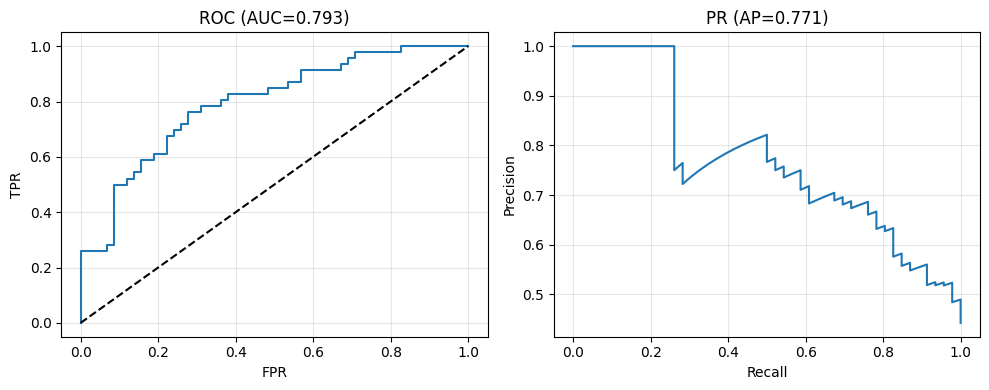

In [30]:
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(y_test, err_test)
prec, rec, _ = precision_recall_curve(y_test, err_test)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'k--')
plt.title(f"ROC (AUC={roc_auc_score(y_test, err_test):.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(alpha=0.3)

plt.subplot(1,2,2); plt.plot(rec, prec)
plt.title(f"PR (AP={average_precision_score(y_test, err_test):.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# 10) Kaydet / Yükle / Tek satır tahmin
**Neden?** Üretimde **aynı scaler + aynı model** ile skoru hesaplayıp **eşikle** karar veririz.

In [31]:
import joblib, json

# Kaydet
ae.save("ae_fraud_best.keras")
joblib.dump(scaler, "scaler_ae.joblib")
json.dump({"threshold_f1": float(thr_f1),
           "threshold_p90": float(thr_p)},
          open("ae_thresholds.json","w"))

# Yükle
scaler2 = joblib.load("scaler_ae.joblib")
ae2 = tf.keras.models.load_model("ae_fraud_best.keras")

thr_cfg = json.load(open("ae_thresholds.json"))
thr_use = thr_cfg["threshold_f1"]   # ya da "threshold_p90"

# Tek satır skor & karar
def ae_score_and_label(x_row, model, scaler, thr):
    # x_row: pandas Series veya 1D array (Class hariç kolonlar)
    x = np.asarray(x_row, dtype="float32").reshape(1, -1)
    xs = scaler.transform(x)
    xr = model.predict(xs, verbose=0)
    err = float(np.mean((xs - xr)**2))
    label = int(err >= thr)
    return err, label

In [32]:
# Örnek:
row = X_test.iloc[0] if isinstance(X, pd.DataFrame) else X_test[0]
print(row)
score, label = ae_score_and_label(row, ae2, scaler2, thr_use)
print("Score:", score, "| Label(1=anomali):", label)

A1       1.00
A2      18.17
A3       2.46
A4       2.00
A5       8.00
A6       7.00
A7       0.96
A8       0.00
A9       1.00
A10      2.00
A11      1.00
A12      2.00
A13    160.00
A14    588.00
Name: 299, dtype: float64
Score: 0.14620956778526306 | Label(1=anomali): 0


## Nerelere “kendi verini” koyacaksın?

* **Sadece şu satırı** değiştir: `CSV_PATH = "creditcard.csv"`
  (Eğer kolon adların farklıysa `y = df["Class"]` ve `X = df.drop(columns=["Class"])` kısmını kendi etiket adına göre düzenle.)

## Hızlı “neden” özeti

* **Sadece normalle eğit**: AE normal paterni öğrenir; anomaliyi yüksek hatayla rekonstrükte eder.
* **Valid’de eşik seç**: Tuning test’e sızmasın; test sadece rapor.
* **PR-AUC ve F1-opt**: Fraud gibi maliyetli alanlarda **PR eğrisi** daha anlamlı.
* **Kaydet/Yükle**: Üretimde aynı scaler+model+threshold ile **tek satır skoru** hesaplayabil.

## İyileştirme fikirleri

* **Latent/hidden** boyutlarıyla küçük grid-search (latent: 8–32, hidden: 32–128).
* **Regularization**: Dropout, L1/L2 (decoder’ı zorlamak genellemeyi artırır).
* **Loss**: MAE dene (`loss="mae"`), bazen anomali ayrımında daha iyi.
* **Only-normal valid**: Valid’i de sadece normal seçip eşiği testte ROC-PR üzerinden belirlemek farklı bir strateji (iş kuralına göre).

Hazırsa bu akışı olduğu gibi çalıştır; çıkan **ROC/PR, F1, rapor/CM** sonuçlarını gönder—birlikte yorumlayıp, gerekirse hiperparametreleri küçükçe ayarlarız.
